#Zadanie 2 (7 pkt)
Celem zadania jest rozwiązanie zadania optymalizacji przy pomocy algorytmu genetycznego. Należy znaleźć minimum zadanej funkcji:
\begin{equation}
f(x) = 1.5-\exp \left\{-x_1^2-x_2^2\right\}-0.5 \exp \left\{-\left(x_1-1\right)^2-\left(x_2+2\right)^2\right\}
\end{equation}
Należy wykorzystać mechanizmy krzyżowania punktowego, mutacji oraz selekcji turniejowej. Proszę wykorzystać przygotowany szkielet i zaimplementować niezbędne metody. Opracowane oprogramowanie powinno być uniwersalne - wymiar funkcji, której minimum szukamy może być dowolny (mechanizm *args). Punktacja wygląda następująco:

*   Stworzenie obiektu klasy *Chromosome* z polem *array*, które jest wektorem aktywnych i nieaktywnych genów - **0.5 pkt**
*   Implementacja metody *decode*, która dekoduje część chromosomu (określoną przez początek (*lower_bound*) i koniec (*upper_bound*)) do postaci liczby rzeczywistej. *aoi* to zakres wartości zdekodowanej liczby rzeczywistej. Przykład: liczba 135 w postaci binarnej zapisana przy użyciu 8 bitów to 1000 0111, jeśli nasze *aoi* to [0, 1], to 135 sprowadzone do tego zakresu to 0.529. Można skorzystać z funkcji pomocniczej *min_max_norm* - **1 pkt**
*   Implementacja metody *mutation*, która przyjmuje jako argument prawdopodobieństo mutacji i zmienia wartość jedego, losowego genu na przeciwną - **0.5 pkt**
*   Implementacja metody *crossover*, która wykonuje operację krzyżowania jednopunktowego - **1 pkt**
*   Implementacja metody *eval_objective_func*, która dekoduje cały chromosom (otrzymuje się argumenty funkcji) oraz zwraca wartość funkcji celu dla tych argumentów - **1 pkt**
*   Implementacja metody *tournament_selection*, która przeprowadza selekcję turniejową - **1 pkt**
*   Implementacja metody *reproduce*, która generuje nowe pokolenie - z pewnym prawdopodobieństwem przeprowadza krzyżowanie jednopunktowe lub "przerzuca" rodziców do nowego pokolenia - **0.5 pkt**
*   Implementacja metody *run*, która wykonuje cały alorytm genetyczny dla określonej liczby pokoleń. W każdym pokoleniu należy zapisać dane osobnika z najlepszym chromosomem zdekodowane wartości x i y oraz wartość funkcji strat dla tego osobnika - **0.5 pkt**
*   Proszę, podobnie jak miało to miejsce w przypadku metody gradientowej z poprzednich zajęć, wygenerować wykres przy użyciu funkcji *plot_func* (w przypadku innego typu argumentu *trace*, funkcję można zmodyfikować. Wykres powinien przedstawiać funkcję, której minimum poszukujemy oraz punkty odpowiadające najlepszym osobnikom w danych generacjach, których kolor jest coraz jaśniejszy wraz ze zbliżaniem się do minimum. Proszę zapisać swoje wnioski, w szczególności w odniesieniu do metody gradientowej. - **1 pkt**


In [290]:
import numpy as np
import matplotlib.pyplot as plt
import functools
import random
import time
random.seed(time.time())

In [291]:
def min_max_norm(val, min_val, max_val, new_min, new_max):
  return (val - min_val) * (new_max - new_min) / (max_val - min_val) + new_min

In [292]:
class Chromosome:
  array = []

  def __init__(self, length, array=None): #if array is None it should be initialized with random binary vector
    self.array = [random.randint(0,1) for _ in range(length)] if array is None else array

  def copy(self):
    return Chromosome(len(self.array), self.array[:])
  # convert binary to decimal, then normalize
  def decode(self, lower_bound, upper_bound, aoi):
    decimal = functools.reduce(lambda x, y: x*2+y, self.array[lower_bound:upper_bound])
    return min_max_norm(decimal,0,2**(upper_bound-lower_bound)-1,*aoi)

  # choose a random position in array and negate it with probability
  def mutation(self, probability):
    mutate = random.randint(0,len(self.array)-1)
    if random.random()<probability:
      #print("Mutating")
      self.array[mutate]^=1

  def crossover(self, other):
    # pick crossover point
    point = random.randint(0,len(self.array)-1)
    self.array[:point],other.array[:point]=other.array[:point],self.array[:point]

In [293]:
from ctypes import Array


class GeneticAlgorithm:
  def __init__(self, chromosome_length, obj_func_num_args, objective_function, aoi, population_size=20,
               tournament_size=2, mutation_probability=0.5, crossover_probability=0.8, num_steps=20, plotmode=None):
    assert chromosome_length % obj_func_num_args == 0, "Number of bits for each argument should be equal"
    self.chromosome_lengths = chromosome_length
    self.obj_func_num_args = obj_func_num_args
    self.bits_per_arg = int(chromosome_length / obj_func_num_args)
    self.objective_function = objective_function
    self.aoi = aoi
    self.tournament_size = tournament_size
    self.mutation_probability = mutation_probability
    self.crossover_probability = crossover_probability
    self.num_steps = num_steps

    self.population_size=population_size
    self.population= []
    self.plotmode=plotmode

  def chromosome_to_arguments(self, chromosome : Chromosome):
    # for each segment...
    segment_size = self.chromosome_lengths//self.obj_func_num_args
    # decode each of it (store in array)
    args = [chromosome.decode(start,start+segment_size,self.aoi) for start in range(0,self.chromosome_lengths,segment_size)]
    return args

  def eval_objective_func(self, chromosome : Chromosome):
    # unpack as arguments
    return self.objective_function(*self.chromosome_to_arguments(chromosome))

  # takes whole population, picks n random contestants, compares them, returns the best one
  # this way the worst chromosome still has chance to survive - he need to be picked n times here
  def tournament_selection(self, population: Array):
    picks = [random.randint(0,len(population)-1) for _ in range(self.tournament_size)]
    bestIndex = min(picks, key=lambda x : self.eval_objective_func(population[x]))
    #print(self.chromosome_to_arguments(population[bestIndex]), "was best with",self.eval_objective_func(population[bestIndex]))
    return population[bestIndex]

 
  # take pairs (n,n+1) for n=0,1,2...k//2, either reproduce (crossover) or leave unchanged
  def reproduce(self, parents):
    for i in range(0,len(parents),2):
      for j in range(1,len(parents),2):
        if random.random()<self.crossover_probability:
          #print("crossing over",self.population[i].array,self.population[j].array)
          parents[i].crossover(parents[j])
          #print("after",self.population[i].array,self.population[j].array)

  def plot_func(self, trace):
    trace = sorted(trace, key=lambda x : self.objective_function(*x), reverse=True)
    X = np.arange(-2, 3, 0.05)
    Y = np.arange(-4, 2, 0.05)
    X, Y = np.meshgrid(X, Y)
    Z = 1.5 - np.exp(-X ** (2) - Y ** (2)) - 0.5 * np.exp(-(X - 1) ** (2) - (Y + 2) ** (2))
    plt.figure()
    plt.contour(X, Y, Z, 10)
    cmaps = [[ii / len(trace), 0, 0] for ii in range(len(trace))]
    plt.scatter([x[0] for x in trace], [x[1] for x in trace], c=cmaps)
    plt.show()

  # 1.do tournament
  # 2.crossover
  # 3.mutate
  def run(self):
    bestpoints = []
    self.population = [Chromosome(self.chromosome_lengths) for _ in range(self.population_size)] # random start

    for iteration in range(self.num_steps):
      best = min(self.population, key=lambda x : self.eval_objective_func(x))
      bestarray = best.array.copy() # preserve the best gene
      if self.plotmode == "trace":
        bestpoints.append(self.chromosome_to_arguments(best))
      
      elif self.plotmode == "everything":
        self.plot_func(np.array([self.chromosome_to_arguments(x) for x in self.population]))

      #print(iteration,"min:",self.chromosome_to_arguments(best))
      # the temp variable is important somehow
      self.population = [self.tournament_selection(self.population).copy() for _ in range(self.population_size)]
      # ---
      self.reproduce(self.population)
      for c in self.population:
        #print("before",c.array)
        c.mutation(self.mutation_probability)
        #print("after",c.array)

      #self.population[0].array = bestarray

    if self.plotmode == "trace":
      self.plot_func(np.array(bestpoints))

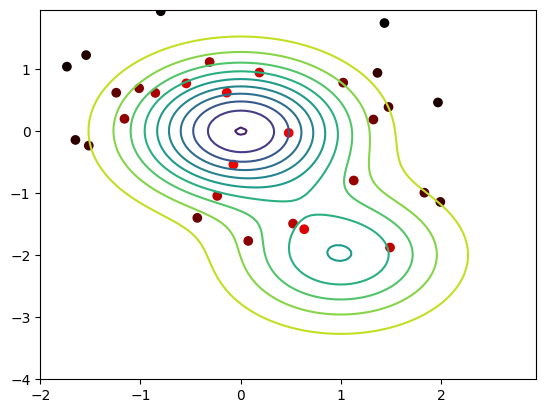

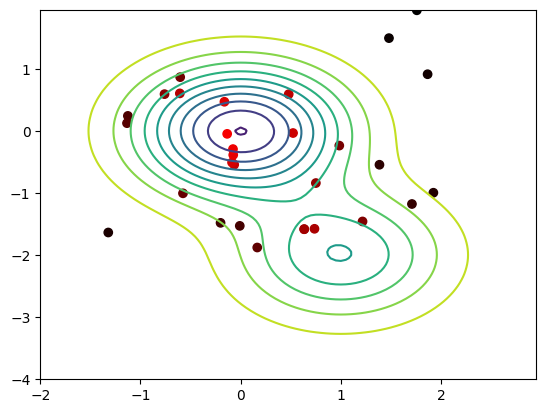

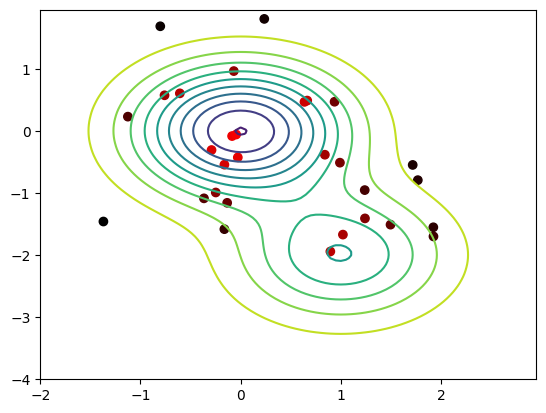

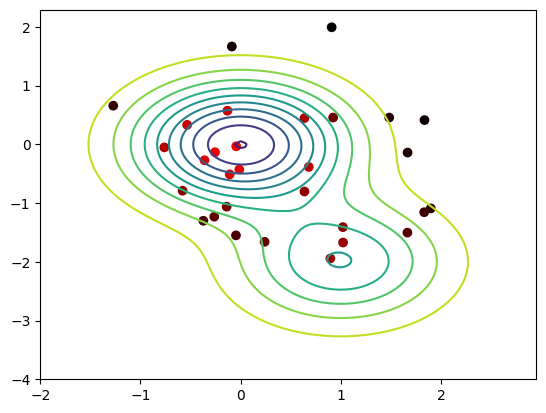

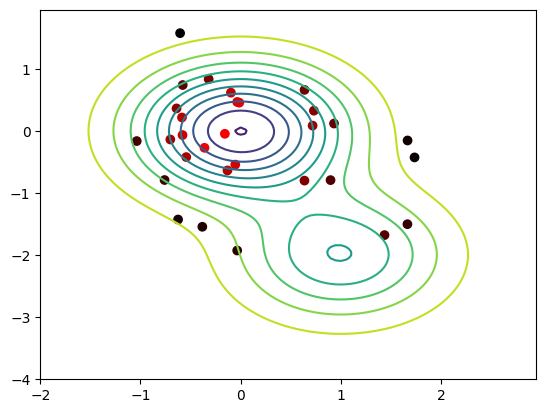

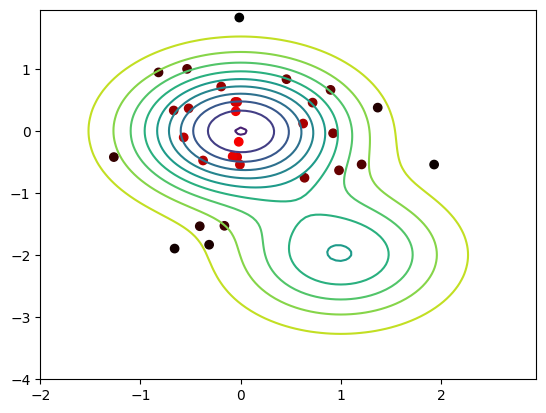

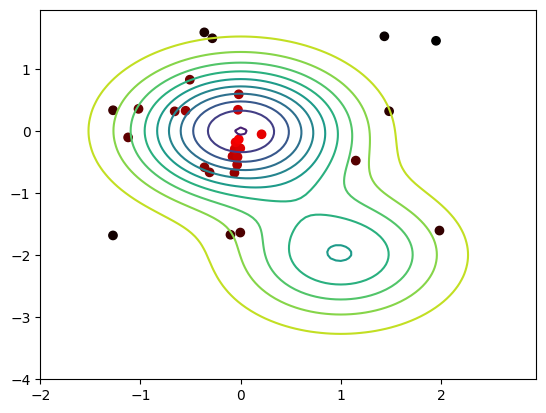

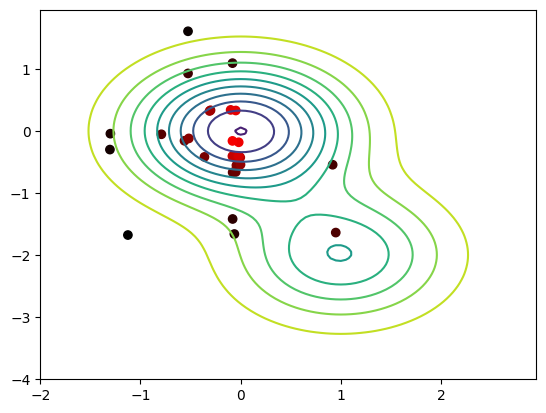

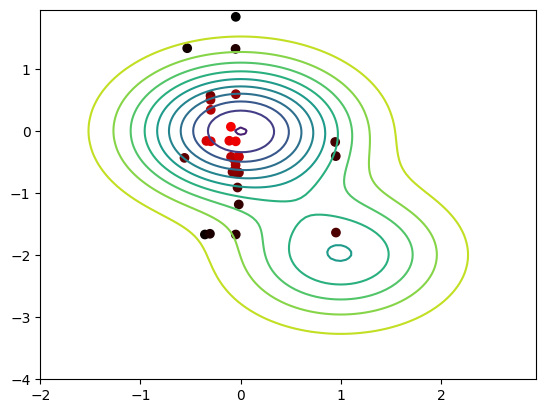

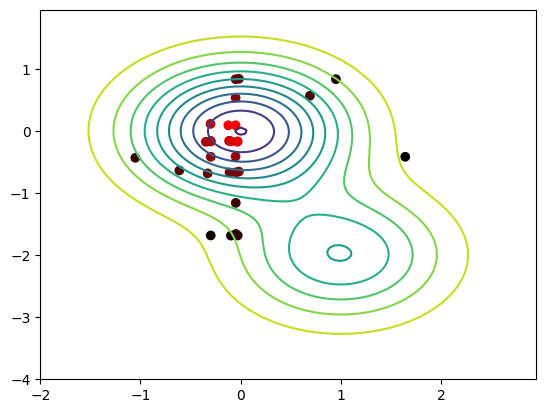

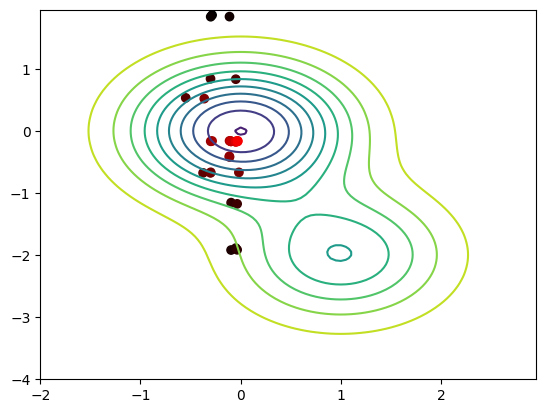

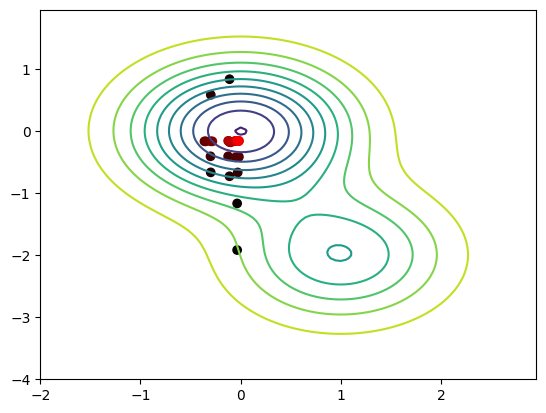

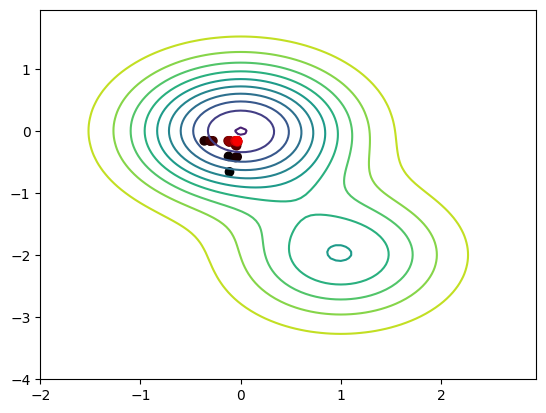

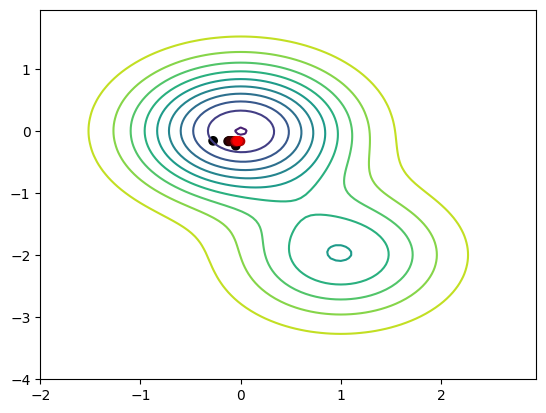

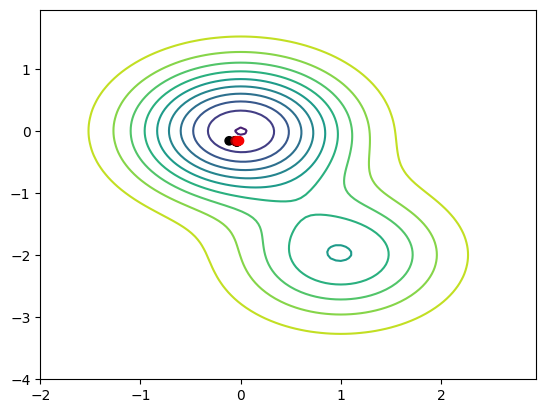

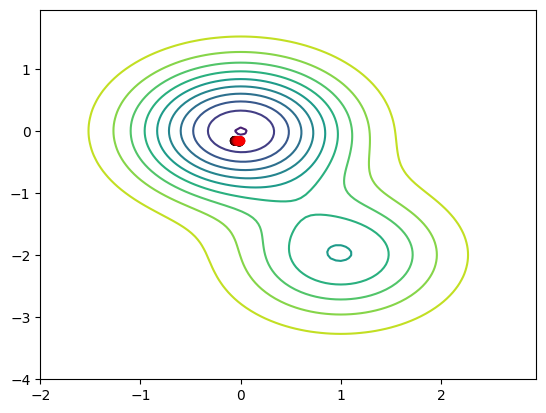

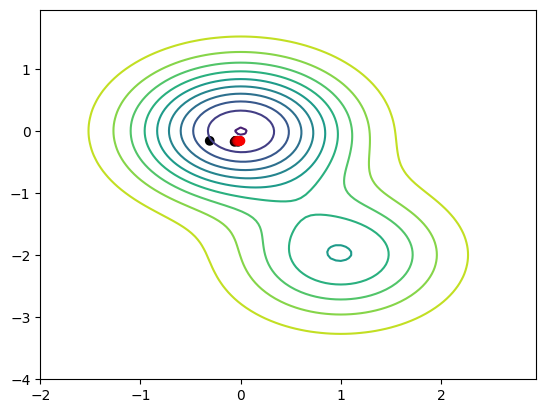

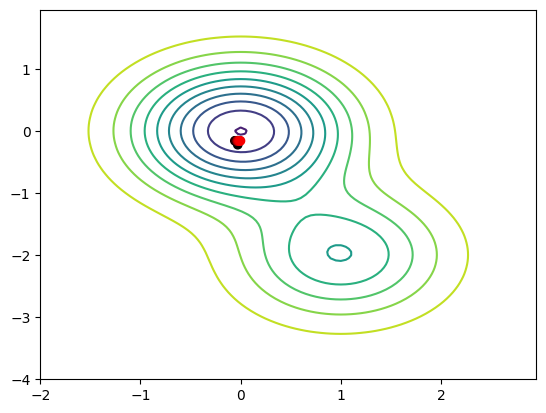

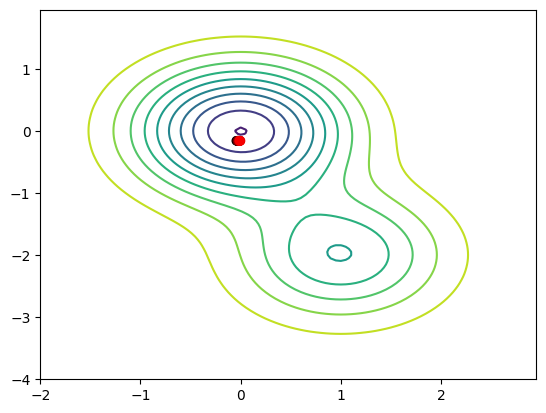

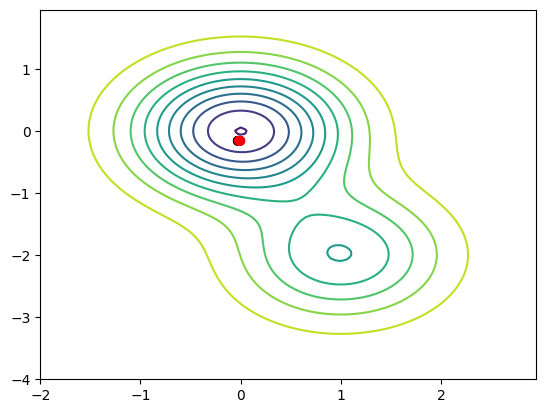

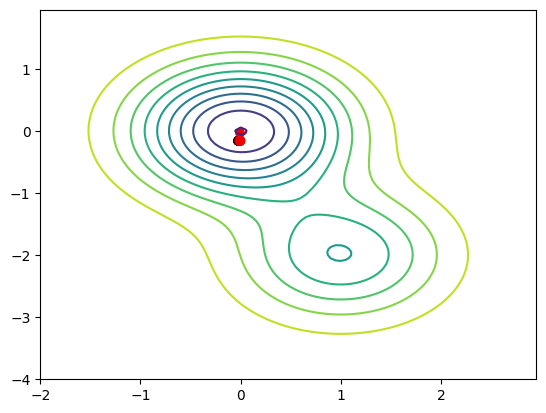

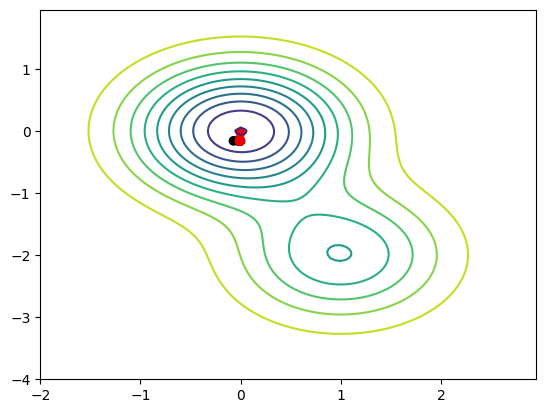

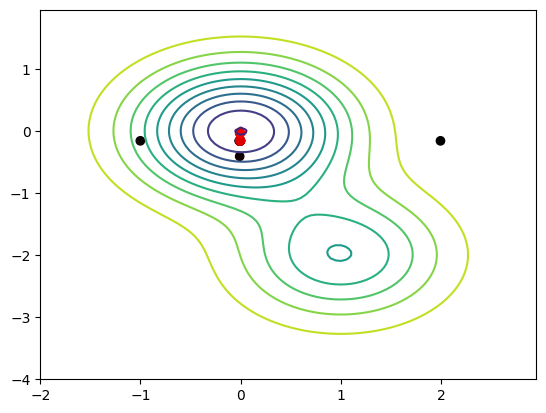

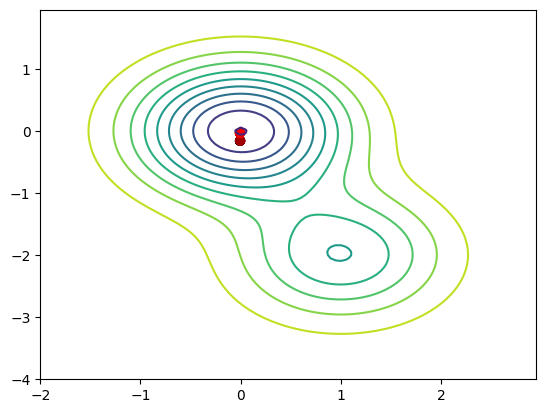

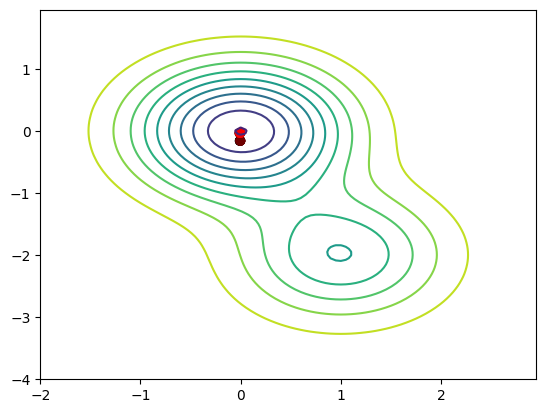

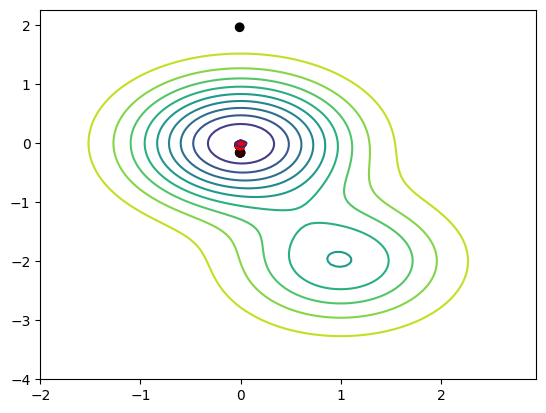

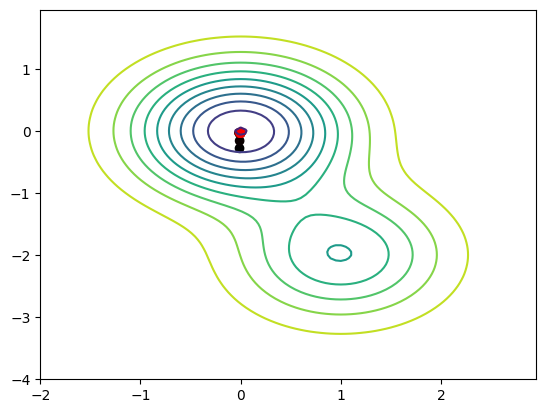

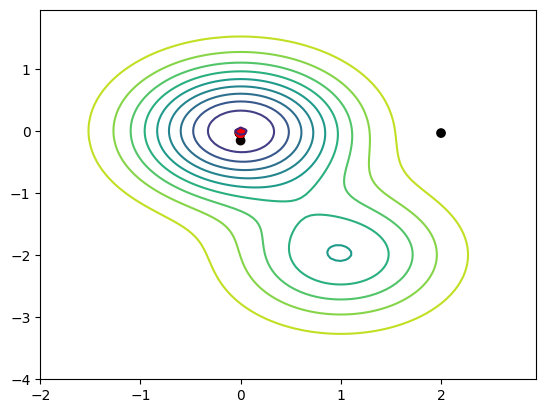

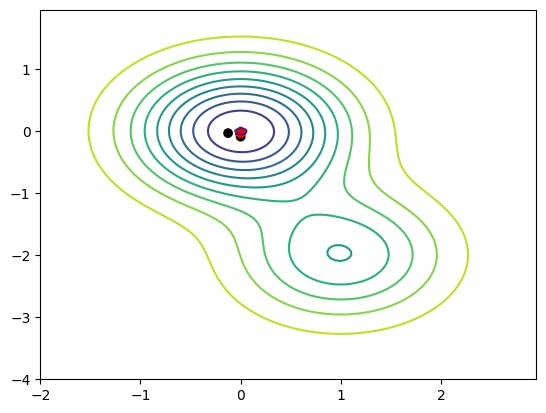

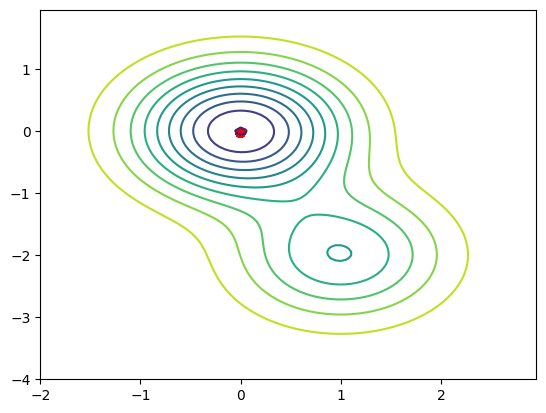

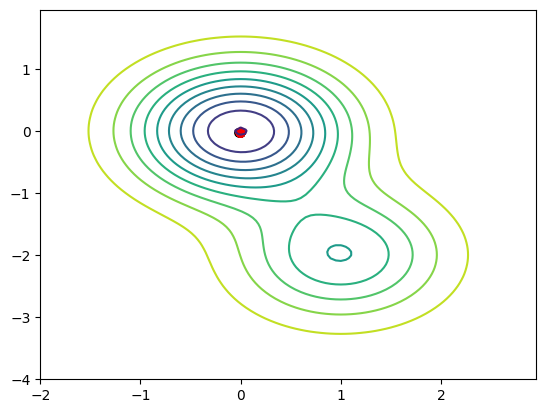

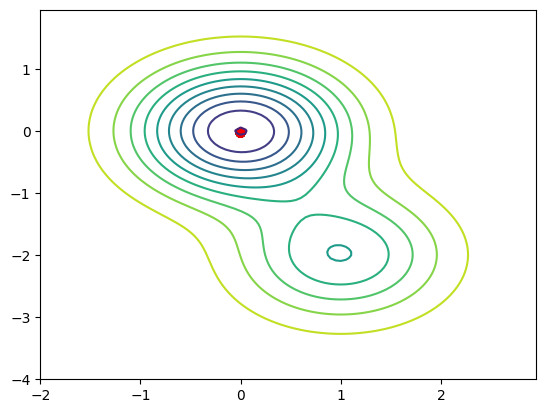

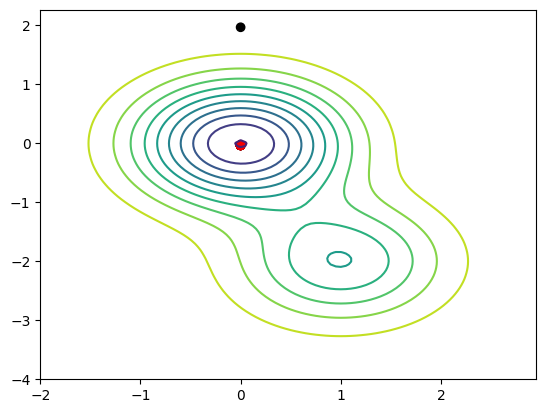

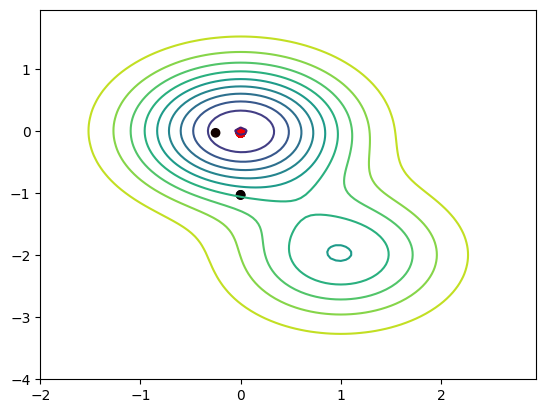

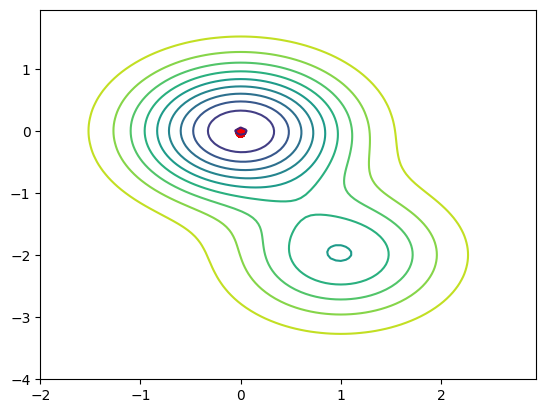

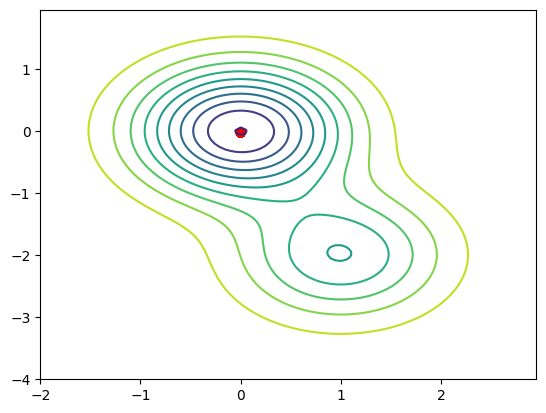

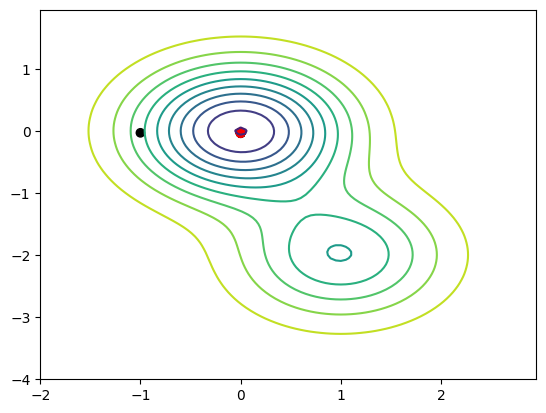

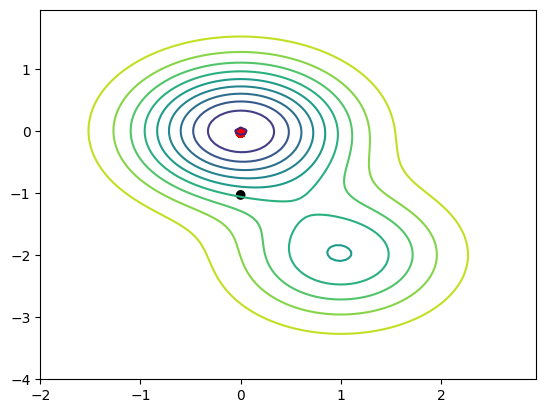

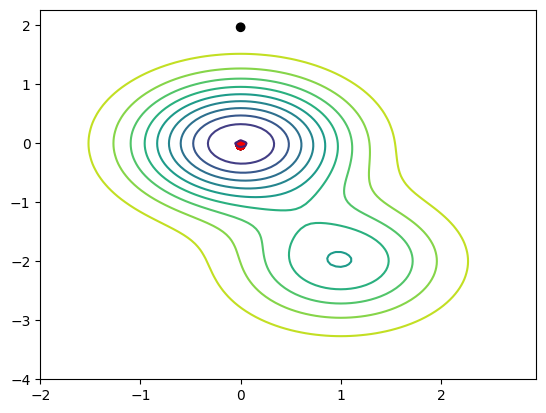

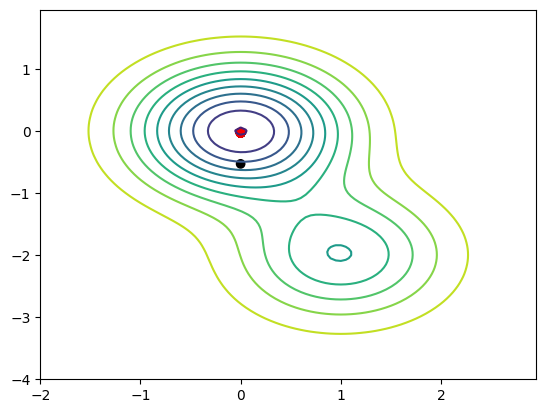

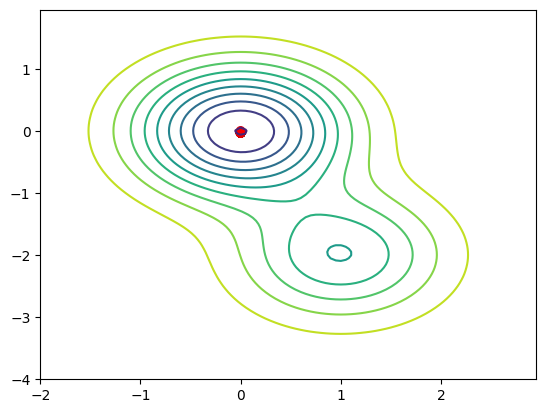

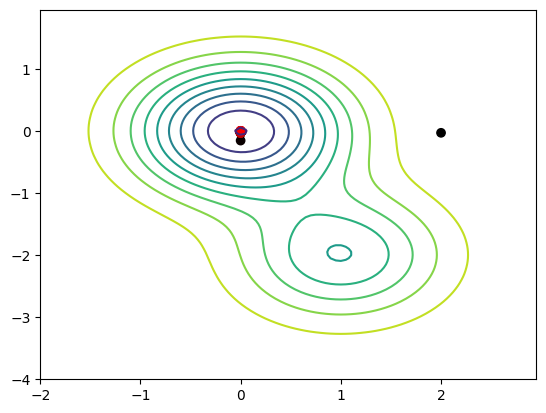

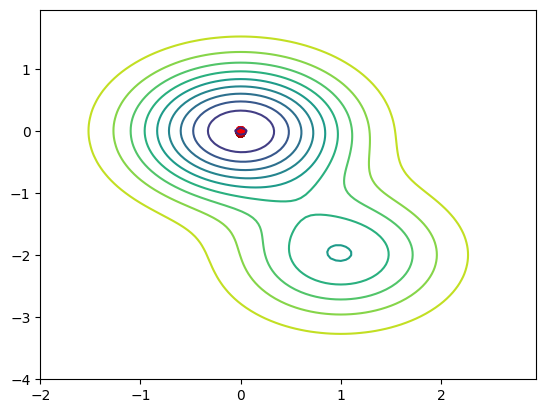

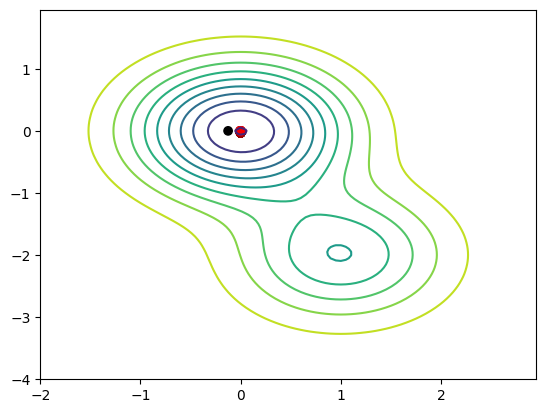

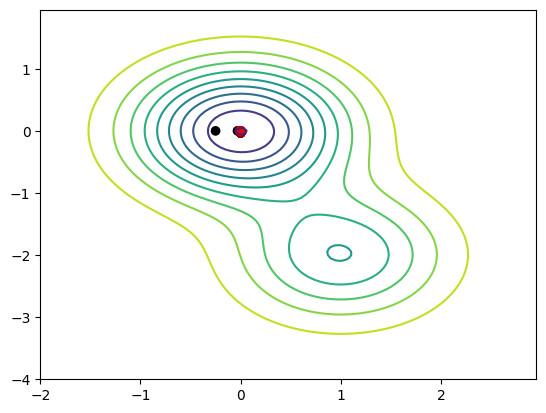

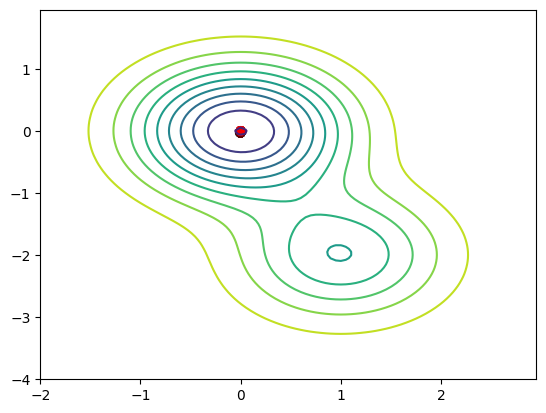

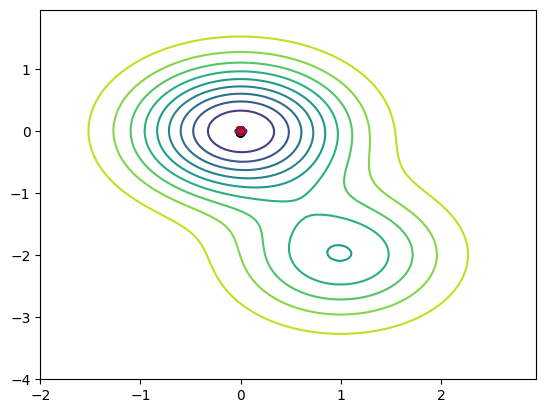

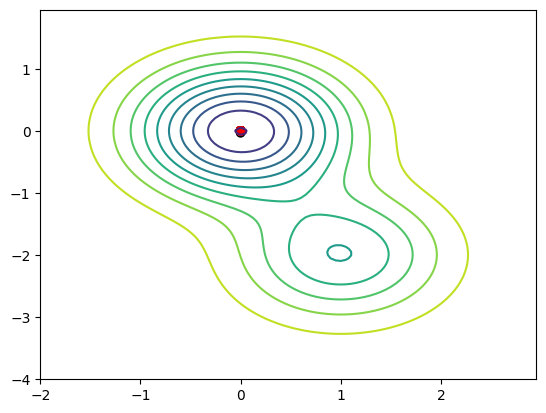

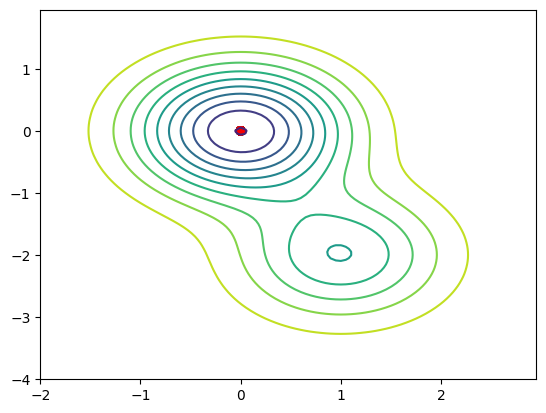

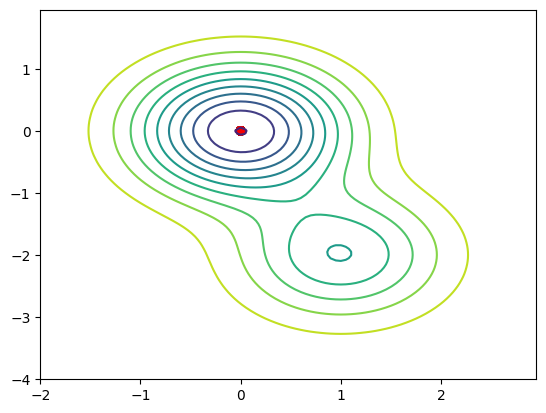

[<__main__.Chromosome object at 0x7fbe1988eb50>, <__main__.Chromosome object at 0x7fbe19b063a0>, <__main__.Chromosome object at 0x7fbe19b065b0>, <__main__.Chromosome object at 0x7fbe19b06610>, <__main__.Chromosome object at 0x7fbe19b06910>, <__main__.Chromosome object at 0x7fbe18bbd610>, <__main__.Chromosome object at 0x7fbe18bbd730>, <__main__.Chromosome object at 0x7fbe18bbd670>, <__main__.Chromosome object at 0x7fbe18bbd3a0>, <__main__.Chromosome object at 0x7fbe18bbd400>, <__main__.Chromosome object at 0x7fbe18bbd2b0>, <__main__.Chromosome object at 0x7fbe18bbd1f0>, <__main__.Chromosome object at 0x7fbe18bbd250>, <__main__.Chromosome object at 0x7fbe18bbd100>, <__main__.Chromosome object at 0x7fbe19b015b0>, <__main__.Chromosome object at 0x7fbe19b01610>, <__main__.Chromosome object at 0x7fbe19b01940>, <__main__.Chromosome object at 0x7fbe19b01e80>, <__main__.Chromosome object at 0x7fbe19b01c10>, <__main__.Chromosome object at 0x7fbe19b01400>, <__main__.Chromosome object at 0x7fbe19

In [294]:
def funct(x,y):
    return 1.5-np.exp(-x**(2)-y**(2))-0.5*np.exp(-(x-1)**(2)-(y+2)**(2))
#chr = Chromosome(8,[1,0,0,1,1,1,1,1])
#chr2 = Chromosome(8,[1,0,1,0,0,0,0,0])

#chr2.crossover(chr)
#print(chr.array,chr2.array)

#print(chr.decode(4,8,[0,2]))

gen = GeneticAlgorithm(32,2,funct,[-2,2],plotmode="everything", population_size=30, num_steps=50, mutation_probability=0.05)
gen.run()